## Plotting copy number and error rate from Supplementary Table mmc2 from Ravikumar et al. Cell 2018

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
from itertools import chain
import itertools
from collections import defaultdict
import palettable as pal

In [37]:
import seaborn as sns
%matplotlib inline
sns.set_context("talk",rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":20})
sns.set_style("whitegrid",{"grid.color": '.9', 'grid.linestyle': '--','axes.edgecolor': '.6', \
                           'xtick.bottom': True,'ytick.left': True})

Function to find duplicates in a list

In [38]:
def list_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)
    return ((key,locs) for key,locs in tally.items() 
                            if len(locs)>1)

def get_statistics_duplicates(polymerase, mu):
    mean_mu = []
    std_mu = []
    mean_cn = []
    std_cn = []
    dup_indeces = []
    names = []

    for dup in list_duplicates(polymerase):
        indeces = dup[1]
        names.append(dup[0])
        mean_mu.append(sum([mu[i] for i in indeces])/len(dup[1]))
        std_mu.append(np.std(np.asarray([mu[i] for i in indeces])))
        mean_cn.append(sum([copy_number[i] for i in indeces])/len(dup[1]))
        std_cn.append(np.std(np.asarray([copy_number[i] for i in indeces])))
        
        for i in range(0,len(indeces)-1):
            #print(dup, indeces[i])
            dup_indeces.append(indeces[i])
        
    all_indeces = list(range(0, len(polymerase)))
    nondup_indeces = list(set(all_indeces) - set(dup_indeces))

    return dup_indeces, nondup_indeces, mean_mu, std_mu, mean_cn, std_cn, names

### Import the data from Excel

In [39]:
# Need openpyxl to import xlsx files on Mac OS
xfile = pd.read_excel('1-s2.0-S0092867418313308-mmc2_reformatted.xlsx',engine='openpyxl')

# Print column names
print(xfile.columns)

# Get values in Excel columns by name
copy_number = xfile['copy number'].values
mu = xfile['mu actual'].values
notes = xfile['Notes'].values
# Reformatted the Excel file: unmerge cells (home tab), F5, blank (find blank cells)
# formula to equal above content, ctr+enter to apply to all
polymerase = xfile['TP-DNAP1 '].values
CI_upper = xfile['CI UPPER'].values
CI_lower = xfile['CI LOWER'].values

print(len(mu), len(notes), len(polymerase))

# Delete nans coming from the excel file formatting I guess
copy_number = [x for x in copy_number if str(x) != 'nan']
mu = [x for x in mu if str(x) != 'nan']
notes = [x for x in notes if str(x) != 'nan']
polymerase = [x for x in polymerase if str(x) != 'nan']
CI_upper = [x for x in CI_upper if str(x) != 'nan']
CI_lower = [x for x in CI_lower if str(x) != 'nan']

print(len(mu), len(notes), len(polymerase))

Index(['TP-DNAP1 ', 'p1 copy number (n)', 'Mutation rate (s.p.b.)',
       'Lower 95% C.I. (s.p.b.)', 'Upper 95% C.I. (s.p.b.)',
       'Number of replicates', 'Notes', 'copy number', 'mu, prefactor',
       'mu, exponential', 'mu actual', 'tmp', 'tmp1', 'CI LOWER', 'tmp2',
       'tmp3', 'CI UPPER'],
      dtype='object')
317 317 317
317 317 317


Computing the number of mutations in each polymerase, identify which variants have one or more mutations

In [41]:
nmut = []
for i in range(len(polymerase)):
    nmut.append(len(polymerase[i].split()))

singlemut = np.where(np.asarray(nmut) == 1)[0]
moremut = np.where(np.asarray(nmut) > 1)[0]

### Finding the entries with multiple measurements and consider the statistics

In [42]:
dup_indeces, nondup_indeces, mean_mu, std_mu, mean_cn, std_cn, names = get_statistics_duplicates(polymerase, mu)

In [43]:
print("Duplicates: ", len(dup_indeces), 'Unique: ', len(nondup_indeces), "Total: ", len(dup_indeces)+len(nondup_indeces))

Duplicates:  104 Unique:  213 Total:  317


In [44]:
pol = 'L477V, L640Y, I777K, W814N'
#pol = 'N371M'

In [45]:
mu_mean = []
mu_std = []
copy_number_mean = []
copy_number_std = []
polymerase_stat = []

# Appending mean values from different measurements of the same polymerase
polymerase_stat.append(names)
mu_mean.append(mean_mu)
mu_std.append(std_mu)
copy_number_mean.append(mean_cn)
copy_number_std.append(std_cn)

# Appending the values from just one measurement
polymerase_stat.append([polymerase[i] for i in nondup_indeces])
mu_mean.append([mu[i] for i in nondup_indeces])
copy_number_mean.append([copy_number[i] for i in nondup_indeces])

# Flattening the list
mu_mean = [item for sublist in mu_mean for item in sublist]
mu_std = [item for sublist in mu_std for item in sublist]
polymerase_stat = [item for sublist in polymerase_stat for item in sublist]
copy_number_mean = [item for sublist in copy_number_mean for item in sublist]
copy_number_std = [item for sublist in copy_number_std for item in sublist]

# Can also use:
# merged = list(itertools.chain(*mu_mean))

Number of polymerases:  317


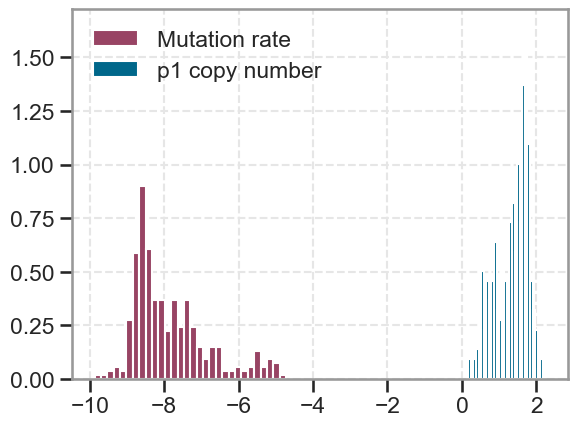

In [46]:
plt.hist(np.log10(mu), density=True, bins=30, color='#984464', label='Mutation rate')
plt.hist(np.log10(copy_number), density=True, bins=30, color="#00678A", label='p1 copy number')
plt.legend(frameon=False)
print("Number of polymerases: ", len(mu))

### Find particular regions in the amino acid sequence and their mapping into mutations in the polymerase

In [47]:
def find_region(polymerase, aa_range):
    
    tmp = 0
    idx = []
    for s in polymerase:
        for num_aa in aa_range:
            #print(str(num_aa), s)
            if str(num_aa) in s:
                #print(str(num_aa), s)
                idx.append(tmp)
        tmp += 1
        
    polymerase_region = [polymerase[i] for i in idx]
    
    return polymerase_region, idx

Selecting the polymerase data with mutations in the amino acids corresponding to the exonuclease motifs and polymerase motifs

In [48]:
aa_exo1 = range(352, 363)
exo_1, idx1 = find_region(polymerase, aa_exo1)

aa_exo2 = range(422, 451)
exo_2, idx2 = find_region(polymerase, aa_exo2)

aa_exo3 = range(550, 564)
exo_3, idx3 = find_region(polymerase, aa_exo3)

# Merging all exonuclease domains and merging all polymerase domains
aa_exon = list(chain(aa_exo1, aa_exo2, aa_exo3, range(463, 484), range(488, 494), range(534, 540)))
exon, idx_exon = find_region(polymerase, aa_exon)

aa_poly = list(chain(range(640, 651), range(748, 760), range(776, 788), range(840, 847), range(862, 872), range(914, 918)))
poly, idx_poly = find_region(polymerase, aa_poly)

# Mutations both in the exonuclease and in the polymerase
idx_double_ = list(set(idx_poly).intersection(idx_exon))

Selecting the polymerase data with mutations in the amino acid that correspond to the full exonuclease and polymerase region

In [49]:
aa_exo = range(352, 597)
exo, idx_exo = find_region(polymerase, aa_exo)

aa_pol = range(597, 988)
pol, idx_pol = find_region(polymerase, aa_pol)

idx_double = list(set(idx_pol).intersection(idx_exo))

In [50]:
print("Motifs", "Pol", len(idx_poly), "Exo", len(idx_exon))
print("Whole region", "Pol", len(idx_pol), "Exo", len(idx_exo))

Motifs Pol 139 Exo 88
Whole region Pol 290 Exo 141


The last 27 values of the Excel file correspond to the WT, then there are reported the highly error-prone polymerases TP-DNAP1-4-2 (the most error-prone) and TP-DNAP1-4-1.

|Name pol| Mutation               |
|--------|------------------------|
|pAR-318:| WT polymerase          |
|pAR-520:| N423D                  |
|pAR-633:| L477V-L640Y-I777K-W814N (TP-DNAP1-4-2)|
|pAR-632:| L474W-L640Y-I777K-W814N|
|pAR-611:| I777K, L900S           |

In [54]:
print('Error rate per cell\n')
print("pAR-318: ", np.mean(np.asarray(mu[-27:])*np.asarray(copy_number[-27:])))
print("pAR-633: ", np.mean(np.asarray(mu[-33:-27])*np.asarray(copy_number[-33:-27])))
print("pAR-520: ", np.mean(np.asarray(mu[39:44])*np.asarray(copy_number[39:44])))
print("pAR-611: ", np.mean(np.asarray(mu[-61:-58])*np.asarray(copy_number[-61:-58])))
print("\n")
print('Error rate\n')
print("pAR-318: ", np.mean(np.asarray(mu[-27:])))
print("pAR-633: ", np.mean(np.asarray(mu[-33:-27])))
print("pAR-520: ", np.mean(np.asarray(mu[39:44])))
print("pAR-611: ", np.mean(np.asarray(mu[-61:-58])))
print("\n")
print('Copy number\n')
print("pAR-318: ", np.mean(np.asarray(copy_number[-27:])))
print("pAR-633: ", np.mean(np.asarray(copy_number[-33:-27])))
print("pAR-520: ", np.mean(np.asarray(copy_number[39:44])))
print("pAR-611: ", np.mean(np.asarray(copy_number[-61:-58])))

Error rate per cell

pAR-318:  1.362599259259259e-07
pAR-633:  8.485984999999999e-05
pAR-520:  1.949472e-06
pAR-611:  2.9093733333333332e-05


Error rate

pAR-318:  2.3981481481481484e-09
pAR-633:  1.1336666666666668e-05
pAR-520:  3.044e-07
pAR-611:  1.9906666666666664e-06


Copy number

pAR-318:  57.762962962962966
pAR-633:  7.98
pAR-520:  7.397999999999999
pAR-611:  16.0


### Code to identify the Pareto front given a scatter plot

In [17]:
from tqdm.notebook import trange, tqdm
def identify_pareto(xy):
    # Count number of items
    population_size = xy.shape[0]

    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)

    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in tqdm(range(population_size)):
        
        # Loop through all other items
        for j in range(population_size):
            
            # Check if our 'i' pint is dominated by out 'j' point
            if (xy[j][0] >= xy[i][0])*(xy[j][1] <= xy[i][1])*( (xy[j][0] > xy[i][0]) or (xy[j][1] < xy[i][1])):
               
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]

In [18]:
xx = np.asarray(mu)
yy = 1/np.asarray(copy_number)
xy = np.concatenate([xx, yy]).reshape(2, len(xx)).T
print(xy.shape[0],xy.shape[1])
pareto = identify_pareto(xy)
idx_pareto_sorted = np.argsort(xy[pareto,0])
pareto_sorted = pareto[idx_pareto_sorted]
print(pareto)

317 2


  0%|          | 0/317 [00:00<?, ?it/s]

[  3  10  12  14  15  16  38  46 116 154 234 250 256 257 258 269 284 285
 286 288]


In [19]:
import copy
xfill = list(xy[pareto_sorted,0])
yfill = list(xy[pareto_sorted,1])
xfill.insert(0,0.0000000001)
yfill.insert(0,yfill[0])
xfill.insert(len(xfill),0.0001)
yfill.insert(len(yfill),max(yfill))

### Plot the scatter plot between 1/copy number and error rate

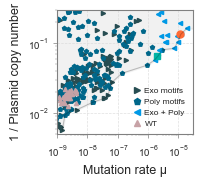

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import copy

# Use the same width and aspect ratio as in Untitled-1
fig_width_inches = 2  # Width in inches (same as other figure)
original_ratio = 4.6/4.2  # Same aspect ratio as Untitled-1
fig_height_inches = fig_width_inches / original_ratio

# Create figure with explicit fixed position axes
fig = plt.figure(figsize=(fig_width_inches, fig_height_inches), facecolor='none')

# Define explicit axes position: [left, bottom, width, height] in figure fraction
# These values control the position of the plotting area within the figure
ax = fig.add_axes([0.25, 0.25, 0.68, 0.68], facecolor='none')

# Optional: Force aspect ratio of the data display (depends on your preference)
# This controls how the data itself is scaled inside the plotting area
# Set to 'auto' for matplotlib to choose, or use a number (e.g., 1.0 for square)
ax.set_aspect('auto')

# Set border
for spine in ax.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(0.8)

# Plot data points
idx_red = list(set(idx_exo) - set(idx_double))
ax.plot([mu[i] for i in idx_red], [1/copy_number[i] for i in idx_red], '>', color='#274D52', 
        markersize=3, label='Exo motifs')

idx_red = list(set(idx_pol) - set(idx_double))
ax.plot([mu[i] for i in idx_red], [1/copy_number[i] for i in idx_red], 'p', color='#00678A', 
        markersize=3, label='Poly motifs')

ax.plot([mu[i] for i in idx_double_], [1/copy_number[i] for i in idx_double_], '<', 
        color=pal.wesanderson.Zissou_5.mpl_colors[0], 
        markersize=3, label='Exo + Poly')

ax.plot(mu[-27:], 1/np.asarray(copy_number[-27:]), '^', color='#C7A2A6', 
        markersize=3, label='WT')

ax.plot(np.mean(mu[-33:-27]), np.mean(1/np.asarray(copy_number[-33:-27])), 'o', color='#FF6B35', markersize=5)
ax.plot(np.mean(mu[-61:-58]), np.mean(1/np.asarray(copy_number[-61:-58])), 's', color='#00B4A6', markersize=5)

ax.plot(np.asarray(mu)[pareto_sorted], 1/np.asarray(copy_number)[pareto_sorted], '-', 
        color='black', linewidth=0.8, alpha=0.2)
ax.fill_between(xfill, yfill, y2=1, color='lightgray', alpha=0.3)

# Set up the grid for major ticks only with light gray lines
ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='lightgray', alpha=0.7)
ax.grid(False, which='minor')  # Turn off minor grid lines

# Set scales
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([1e-9, 3e-5])
ax.set_ylim([5e-3, 0.3])

# Enable minor ticks for both log scales
ax.minorticks_on()

# Format axes - set tick label size and ensure ticks are visible
ax.tick_params(axis='both', labelsize=7, colors='0.15')
ax.tick_params(axis='both', which='major', width=0.5, length=3.0, color='gray')
ax.tick_params(axis='both', which='minor', width=0.3, length=1.5, color='gray')

# Set specific major ticks for x-axis
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=6))
ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))

# Set labels with proper font sizes
ax.set_xlabel('Mutation rate μ', fontsize=9)
ax.set_ylabel('1 / Plasmid copy number', fontsize=9)

# Add legend in bottom right
legend = ax.legend(frameon=False, 
                  loc='lower right',
                  fontsize=6,
                  markerscale=1.5,
                  handlelength=1.0,
                  handletextpad=0.4)

# Style the legend text
for text in legend.get_texts():
    text.set_color('0.15')
    
# Save with explicit settings
#plt.savefig('scatter_polymerases_ChangLiu_exo2.pdf', 
#            dpi=300, 
#            transparent=True) 

### Plotting the full range

In [21]:
import copy
xfill = list(xy[pareto_sorted,0])
yfill = list(xy[pareto_sorted,1])
xfill.insert(0,0.0000000001)
yfill.insert(0,yfill[0])
xfill.insert(len(xfill),0.0001)
yfill.insert(len(yfill),max(yfill))

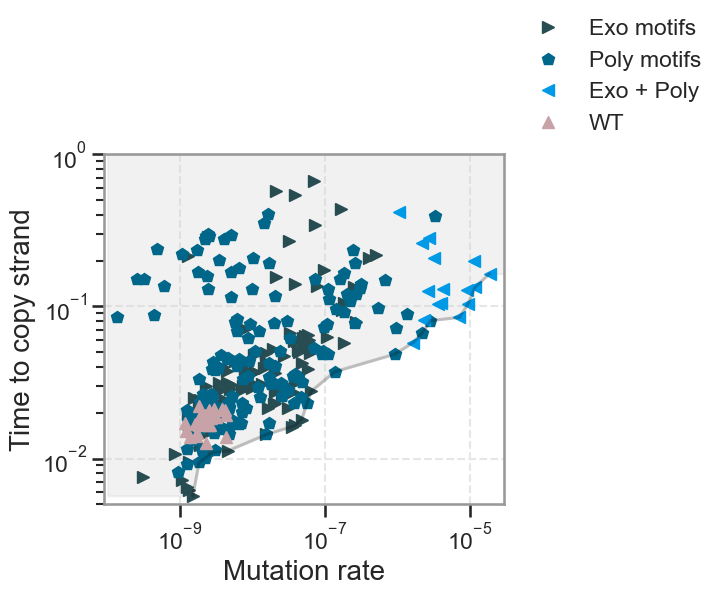

In [22]:
fig = plt.figure(figsize=(4, 3.5))
ax = fig.add_axes([0,0,1,1])

#ax.plot(mu, copy_number, 'o', color='blue')

idx_red = list(set(idx_exo) - set(idx_double))
ax.plot([mu[i] for i in idx_red], [1/copy_number[i] for i in idx_red], '>', color='#274D52', \
        markersize=9, label='Exo motifs')

idx_red = list(set(idx_pol) - set(idx_double))
ax.plot([mu[i] for i in idx_red], [1/copy_number[i] for i in idx_red], 'p', color='#00678A', \
        markersize=9, label='Poly motifs')

ax.plot([mu[i] for i in idx_double_], [1/copy_number[i] for i in idx_double_], '<', color=pal.wesanderson.Zissou_5.mpl_colors[0], \
        markersize=9, label='Exo + Poly')

ax.plot(mu[-27:], 1/np.asarray(copy_number[-27:]), '^', color='#C7A2A6', markersize=9, label='WT')

ax.plot(np.asarray(mu)[pareto_sorted], 1/np.asarray(copy_number)[pareto_sorted], '-', color='black', markersize=9, alpha=0.2)
plt.fill_between(xfill, yfill, \
                 y2=1, color='lightgray', alpha=0.3)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.9e-10,3e-5])
ax.set_ylim([5e-3,1])

plt.legend(frameon=False, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Copy number p1")
plt.ylabel("Time to copy strand")
plt.xlabel("Mutation rate")

#plt.savefig('scatter_polymerases_ChangLiu_exo2si.pdf', bbox_inches='tight')

### Organising data based on which approach the variants are obtained with

In [23]:
s = 'From homology study'
print(np.asarray(notes)[nondup_indeces].tolist().count(s), np.asarray(notes).tolist().count(s))
s = 'From homology study; Rd1 mutant'
print(np.asarray(notes)[nondup_indeces].tolist().count(s), np.asarray(notes).tolist().count(s), '\n')

s = 'From saturation mutagenesis library'
print(np.asarray(notes)[nondup_indeces].tolist().count(s), np.asarray(notes).tolist().count(s))
s = 'From saturation mutagenesis library; Rd1 mutant'
print(np.asarray(notes)[nondup_indeces].tolist().count(s), np.asarray(notes).tolist().count(s))
s = 'From saturation mutagenesis library; Rd2 mutant'
print(np.asarray(notes)[nondup_indeces].tolist().count(s), np.asarray(notes).tolist().count(s), '\n')

s = 'From Ravikumar et al., 2014; Rd1 mutant'
print(np.asarray(notes)[nondup_indeces].tolist().count(s), np.asarray(notes).tolist().count(s), '\n')

s = 'From shuffling library (A X B)'
print(np.asarray(notes)[nondup_indeces].tolist().count(s), np.asarray(notes).tolist().count(s))
s = 'From shuffling library (A X B); Rd3 mutant'
print(np.asarray(notes)[nondup_indeces].tolist().count(s), np.asarray(notes).tolist().count(s), '\n')

s = 'From shuffling library (B X C)'
print(np.asarray(notes)[nondup_indeces].tolist().count(s), np.asarray(notes).tolist().count(s))
s = 'From shuffling library (B X C); Rd3 mutant'
print(np.asarray(notes)[nondup_indeces].tolist().count(s), np.asarray(notes).tolist().count(s), '\n')

s = 'Rd4 mutant; Entries 4-6 for this TP-DNAP1 variant are measurements taken after 90 generations.'
print(np.asarray(notes)[nondup_indeces].tolist().count(s), np.asarray(notes).tolist().count(s))
s = 'Entries 24-27 for this TP-DNAP1 variant are measurements taken after 90 generations.'
print(np.asarray(notes)[nondup_indeces].tolist().count(s), np.asarray(notes).tolist().count(s))

63 63
21 23 

34 50
1 1
41 76 

2 6 

22 22
1 2 

21 21
2 4 

1 6
1 27


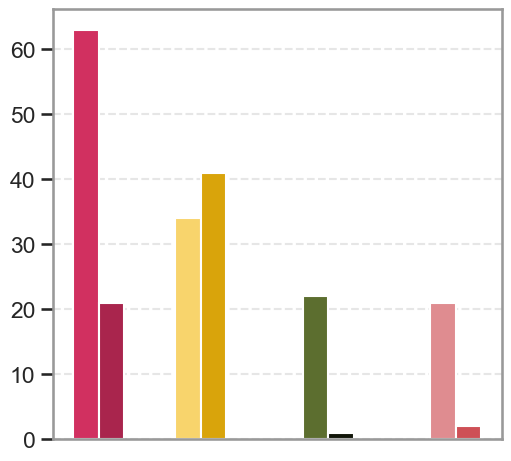

In [24]:
fig, ax = plt.subplots(figsize=(5, 4.5), layout='constrained')
width = 0.05  # the width of the bars
rects = ax.bar(0.0, 63, width, \
                   color=pal.wesanderson.Moonrise5_6.mpl_colors[4])
rects = ax.bar(0.05, 21, width, \
                   color='#a9254d')
# rects = ax.bar(0.2, 13625, width, \
#                    color=pal.wesanderson.Moonrise5_6.mpl_colors[2])
rects = ax.bar(0.2, 34, width, \
                   color='#f8d46c')
rects = ax.bar(0.25, 41, width, \
                   color='#d9a40b')
rects = ax.bar(0.45, 22, width, \
                   color='#5c6e2f')
rects = ax.bar(0.5, 1, width, \
                   color='#111509')

rects = ax.bar(0.7, 21, width, \
                   color=pal.wesanderson.Moonrise5_6.mpl_colors[0])
rects = ax.bar(0.75, 2, width, \
                   color='#ce5056')

ax.set_xticks([])
#ax.set_yscale('log')
#plt.savefig('statistics_cl.pdf', bbox_inches='tight')

In [25]:
def find_region_notes(polymerase, aa_range):
    
    tmp = 0
    idx = []
    for s in polymerase:
        if str(aa_range) in s:
            idx.append(tmp)
        tmp += 1
        
    polymerase_region = [polymerase[i] for i in idx]
    
    return polymerase_region, idx
    
_, idxh1 = find_region_notes(notes, 'From homology study; Rd1 mutant')
_, idxh = find_region_notes(notes, 'From homology study')
_, idxs = find_region_notes(notes, 'From saturation mutagenesis library')
_, idxs1 = find_region_notes(notes, 'From saturation mutagenesis library; Rd1 mutant')
_, idxs2 = find_region_notes(notes, 'From saturation mutagenesis library; Rd2 mutant')
_, idxab = find_region_notes(notes, 'From shuffling library (A X B)')
_, idxab3 = find_region_notes(notes, 'From shuffling library (A X B); Rd3 mutant')
_, idxbc = find_region_notes(notes, 'From shuffling library (B X C)')
_, idxbc3 = find_region_notes(notes, 'From shuffling library (B X C); Rd3 mutant')
_, idx4 = find_region_notes(notes, 'Rd4 mutant; Entries 4-6 for this TP-DNAP1 variant are measurements taken after 90 generations.')
_, idx41 = find_region_notes(notes, 'Rd4 mutant; TP-DNAP1-4-1 Entries 4-6 for this TP-DNAP1 variant are \
measurements taken after 90 generations.')
_, idx42 = find_region_notes(notes, 'Rd4 mutant; TP-DNAP1-4-2; Entries 4-6 for this TP-DNAP1 variant are measurements taken after 90 generations.')

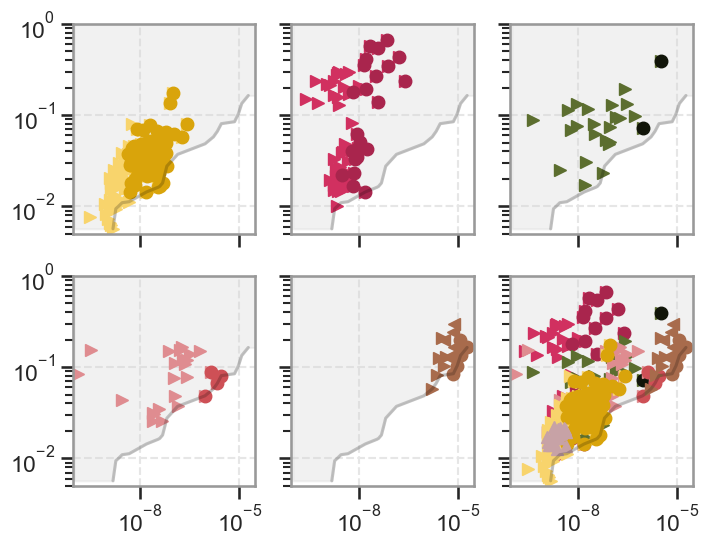

In [26]:
fig,ax = plt.subplots(2,3,figsize=(8, 6),sharex=True,sharey=True)
#ax[0,0] = fig.add_axes([0,0,1,1])

#ax.plot(mu, copy_number, 'o', color='blue')

ax[0,0].plot([mu[i] for i in idxs], [1/copy_number[i] for i in idxs], '>', color='#f8d46c', \
        markersize=9, label='Exo motifs')
ax[0,0].plot([mu[i] for i in idxs1], [1/copy_number[i] for i in idxs1], '<', color=pal.wesanderson.Moonrise5_6.mpl_colors[2], \
        markersize=9, label='Exo motifs')
ax[0,0].plot([mu[i] for i in idxs2], [1/copy_number[i] for i in idxs2], 'o', color='#d9a40b', \
        markersize=9, label='Exo motifs')
ax[0,0].fill_between(xfill, yfill, \
                 y2=1, color='lightgray', alpha=0.3)

ax[0,1].plot([mu[i] for i in idxh], [1/copy_number[i] for i in idxh], '>', color=pal.wesanderson.Moonrise5_6.mpl_colors[4], \
        markersize=9, label='Exo motifs')
ax[0,1].plot([mu[i] for i in idxh1], [1/copy_number[i] for i in idxh1], 'o', color='#a9254d', \
        markersize=9, label='Exo motifs')
ax[0,1].fill_between(xfill, yfill, \
                 y2=1, color='lightgray', alpha=0.3)

ax[0,2].plot([mu[i] for i in idxab], [1/copy_number[i] for i in idxab], '>', color='#5c6e2f', \
        markersize=9, label='Exo motifs')
ax[0,2].plot([mu[i] for i in idxab3], [1/copy_number[i] for i in idxab3], 'o', color='#111509', \
        markersize=9, label='Exo motifs')
ax[0,2].fill_between(xfill, yfill, \
                 y2=1, color='lightgray', alpha=0.3)

ax[1,0].plot([mu[i] for i in idxbc], [1/copy_number[i] for i in idxbc], '>', color=pal.wesanderson.Moonrise5_6.mpl_colors[0], \
        markersize=9, label='Exo motifs')
ax[1,0].plot([mu[i] for i in idxbc3], [1/copy_number[i] for i in idxbc3], 'o', color='#ce5056', \
        markersize=9, label='Exo motifs')
ax[1,0].fill_between(xfill, yfill, \
                 y2=1, color='lightgray', alpha=0.3)

ax[1,1].plot([mu[i] for i in idx4], [1/copy_number[i] for i in idx4], '>', color=pal.wesanderson.Moonrise5_6.mpl_colors[5], \
        markersize=9, label='Exo motifs')
ax[1,1].plot([mu[i] for i in idx41], [1/copy_number[i] for i in idx41], '<', color=pal.wesanderson.Moonrise5_6.mpl_colors[5], \
        markersize=9, label='Exo motifs')
ax[1,1].plot([mu[i] for i in idx42], [1/copy_number[i] for i in idx42], 'o', color=pal.wesanderson.Moonrise5_6.mpl_colors[5], \
        markersize=9, label='Exo motifs')
ax[1,1].fill_between(xfill, yfill, \
                 y2=1, color='lightgray', alpha=0.3)

ax[1,2].plot([mu[i] for i in idxh], [1/copy_number[i] for i in idxh], '>', color=pal.wesanderson.Moonrise5_6.mpl_colors[4], \
        markersize=9, label='Exo motifs')
ax[1,2].plot([mu[i] for i in idxh1], [1/copy_number[i] for i in idxh1], 'o', color='#a9254d', \
        markersize=9, label='Exo motifs')
ax[1,2].plot([mu[i] for i in idxab], [1/copy_number[i] for i in idxab], '>', color='#5c6e2f', \
        markersize=9, label='Exo motifs')
ax[1,2].plot([mu[i] for i in idxab3], [1/copy_number[i] for i in idxab3], 'o', color='#111509', \
        markersize=9, label='Exo motifs')
ax[1,2].plot([mu[i] for i in idxbc], [1/copy_number[i] for i in idxbc], '>', color=pal.wesanderson.Moonrise5_6.mpl_colors[0], \
        markersize=9, label='Exo motifs')
ax[1,2].plot([mu[i] for i in idxbc3], [1/copy_number[i] for i in idxbc3], 'o', color='#ce5056', \
        markersize=9, label='Exo motifs')
ax[1,2].plot([mu[i] for i in idx4], [1/copy_number[i] for i in idx4], '>', color=pal.wesanderson.Moonrise5_6.mpl_colors[5], \
        markersize=9, label='Exo motifs')
ax[1,2].plot([mu[i] for i in idx41], [1/copy_number[i] for i in idx41], '<', color=pal.wesanderson.Moonrise5_6.mpl_colors[5], \
        markersize=9, label='Exo motifs')
ax[1,2].plot([mu[i] for i in idx42], [1/copy_number[i] for i in idx42], 'o', color=pal.wesanderson.Moonrise5_6.mpl_colors[5], \
        markersize=9, label='Exo motifs')
ax[1,2].plot([mu[i] for i in idxs], [1/copy_number[i] for i in idxs], '>', color='#f8d46c', \
        markersize=9, label='Exo motifs')
ax[1,2].plot([mu[i] for i in idxs1], [1/copy_number[i] for i in idxs1], '<', color=pal.wesanderson.Moonrise5_6.mpl_colors[2], \
        markersize=9, label='Exo motifs')
ax[1,2].plot([mu[i] for i in idxs2], [1/copy_number[i] for i in idxs2], 'o', color='#d9a40b', \
        markersize=9, label='Exo motifs')
ax[1,2].plot(mu[-27:], 1/np.asarray(copy_number[-27:]), '^', color='#C7A2A6', markersize=9, label='WT')

ax[0,0].plot(np.asarray(mu)[pareto_sorted], 1/np.asarray(copy_number)[pareto_sorted], '-', color='black', markersize=9, alpha=0.2)
ax[0,1].plot(np.asarray(mu)[pareto_sorted], 1/np.asarray(copy_number)[pareto_sorted], '-', color='black', markersize=9, alpha=0.2)
ax[0,2].plot(np.asarray(mu)[pareto_sorted], 1/np.asarray(copy_number)[pareto_sorted], '-', color='black', markersize=9, alpha=0.2)
ax[1,0].plot(np.asarray(mu)[pareto_sorted], 1/np.asarray(copy_number)[pareto_sorted], '-', color='black', markersize=9, alpha=0.2)
ax[1,1].plot(np.asarray(mu)[pareto_sorted], 1/np.asarray(copy_number)[pareto_sorted], '-', color='black', markersize=9, alpha=0.2)
ax[1,2].plot(np.asarray(mu)[pareto_sorted], 1/np.asarray(copy_number)[pareto_sorted], '-', color='black', markersize=9, alpha=0.2)
plt.fill_between(xfill, yfill, \
                 y2=1, color='lightgray', alpha=0.3)

ax[0,0].set_yscale('log')
ax[0,0].set_xscale('log')
ax[0,0].set_xlim([0.9e-10,3e-5])
ax[0,0].set_ylim([5e-3,1])

#plt.legend(frameon=False, bbox_to_anchor=(1.0, 1.0))
#plt.ylabel("Copy number p1")
#plt.ylabel("Time to copy strand")
#plt.xlabel("Mutation rate")

#plt.savefig('scatter_polymerases_ChangLiu_exo2si.pdf', bbox_inches='tight')